# GDL - Regular Group Convolutions

**Authors:**
David Knigge

## 0. Introduction

In this notebook, we will be implementing regular group convolutional networks from scratch, only making use of PyTorch primitives. The goal is to get familiar with the practical considerations to take into account when actually implementing these convolutional networks.

### 0.1 Brief recap on CNNs

Conventional CNNs make use of the convolution operator, here defined over $\mathbb{R}^2$ for a signal $f:\mathbb{R}^2 \rightarrow \mathbb{R}$ and a kernel $k: \mathbb{R}^2 \rightarrow \mathbb{R}$ at $\mathbf{x}\in \mathbb{R}^2$:

$$
(f * k) (\mathbf{x}) = 
    \int_{\mathbb{R}^2} f(\tilde{\mathbf{x}})k(\tilde{\mathbf{x}} - \mathbf{x}) \text{d}\tilde{\mathbf{x}},
$$

As we can see, the convolution operation comes down to an inner product of the function $f$ and a shifted kernel $k$. 

> Sidenote: In reality CNNs implement a discretised version of this operation;
$$
\begin{aligned}
(f*k) (\mathbf{x}) &= \sum_{\mathbf{\tilde{x}} \in \mathbb{Z}^2} f(\mathbf{\tilde{x}})k(\mathbf{x}-\mathbf{\tilde{x}})\Delta\mathbf{\tilde{x}}\\
&= \sum_{\mathbf{\tilde{x}} \in \mathbb{Z}^2} f(\mathbf{\tilde{x}})k(\mathbf{x}-\mathbf{\tilde{x}})
\end{aligned}
$$   
Where above, since pixels in an image are generally evenly spaced, we set $\Delta \mathbf{\tilde{x}}=1$. For this recap we stay in the continuous domain for simplicity.

In convolution layers, like PyTorch's `Conv2D` implementation, the above operation is carried out for every $\mathbf{x} \in \mathbb{Z}^2$ (limited of course to the domain over which the image is defined). Because the same set of weights is used throughout the input, the output of this operation is [equivariant](https://en.wikipedia.org/wiki/Convolution#Translational_equivariance) to transformations from the translation group $\mathbb{R}^2$. Furthermore $f,k$ usually consist of a number of channels, which are all summed over.


In this tutorial, we will use PyTorch's `torch.nn.functional.conv2d()` function to perform this integration operation at every position in input feature map. This saves us having to implement the convolution operation ourselves.


### 0.2 Brief recap on GCNNs

In regular group convolutions, the goal is to have a CNN of which are not only equivariant to translations $\mathbb{R}^2$, but which are also equivariant to another (usually broader) group of interest $G$. We focus specifically on groups which are combinations of translations $\mathbb{R}^2$ and some group of interest $H$. In this tutorial we keep to the group of 90 degree rotations in 2D; the [Cyclic group](https://en.wikipedia.org/wiki/Cyclic_group) of order 4 $H=C_4$. 

We will operate on 2D images, generally defined on $\mathbb{R}^2$, as such, the first step in constructing a network which can track under which _pose_ (read: transformation from a group $G=\mathbb{R}^2\rtimes H$) a feature in the input occurs, we need to transfer our signal to a domain in which the same feature under a different pose is disentangled. This happens through _the lifting convolution_, which maps features in our input signal $f_{in}:\mathbb{R}^2\rightarrow \mathbb{R}$ to a feature map on the group $f_{out}:G\rightarrow \mathbb{R}$. For a signal and kernel $f,k$ both defined on $\mathbb{R}^2$, and a group element $g=(\boldsymbol{x}, h) \in G=\mathbb{R}^2 \rtimes H$:

$$
(f *_{\text{lifting}} k) (g) = 
\int_{\mathbb{R}^2} f(\tilde{\mathbf{x}})k_h(\tilde{\mathbf{x}} - \mathbf{x}) \,{\rm d}\tilde{\mathbf{x}}.
$$

Where $k_h$ is the kernel $k:\mathbb{R}^2 \rightarrow \mathbb{R}$ transformed under the regular representation $\mathcal{L}_h$ of a group element $h \in H$; $k_h = \frac{1}{| h|}\mathcal{L}_{h}[k]$.

> Sidenote:
The factor $\frac{1}{| h|}$, with $|h|$ the determinant of the matrix representation of $h$ in $\mathbb{R}^2$, accounts for a possible change in volume on $\mathbb{R}^2$ that $h$ might have. Working with the cyclic group, we don't encounter this problem (the determinant of a rotation matrix is 1, volumes are invariant to rotations on $\mathbb{R}^2$), but if you'd like to implement equivariance to for example the dilation group, this becomes important.

Next, now that we have a feature map defined on the group; $f_{out}:G\rightarrow \mathbb{R}$, we apply group convolutions, extending the convolution operation to an integral over the entire group $G$;

$$
\begin{aligned}
(f *_{\mathrm{group}} k) (g) &=\int_G f(\tilde{g})k(g^{-1} \cdot \tilde{g}) {\rm d}\tilde{g} \\
&=\int_{\mathbb{R}^2}\int_H f(\tilde{\mathbf{x}}, \tilde{h})\mathcal{L}_{x}\mathcal{L}_{h}k(\tilde{\mathbf{x}}, \tilde{h})\dfrac{1}{|h|} \,{\rm d}\mathbf{\tilde{x}}\,{\rm d}\tilde{h}\\
&=\int_{\mathbb{R}^2}\int_H f(\tilde{\mathbf{x}},\tilde{h})k({h^{-1}}(\tilde{\mathbf{x}}-\mathbf{x}), h^{-1}\cdot \tilde{h})\dfrac{1}{|h|} \,{\rm d}\mathbf{\tilde{x}}\,{\rm d}\tilde{h}.
\end{aligned}
$$

The main difference with the lifting convolution is that the signal and kernel $f,k$ are both functions on $G$;$G\rightarrow \mathbb{R}$, and the integral reflects this by extending over the entire group $G$. Other than that, there is little difference!

After a number of such group convolutional layers, we will want to ultimately obtain a representation that is invariant to the group action. We can do this by performing a projection which collapses our function defined over $G$ to a single point, with an operation that is invariant to the group action (summing, averaging, max, min).

After this short refresher, let's get to coding!

### 0.3 Installing and importing some useful packages

Here we install and import some libraries that we will use throughout this tutorial. We use the [PyTorch](https://pytorch.org/) as our deep learning framework of choice. Note that for ease of model training and tracking, we additionally make use of [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/).

In [25]:
## Standard libraries
import os
import numpy as np
import math
from PIL import Image
from functools import partial

## Imports for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
## Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
## PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip3 install pytorch-lightning>=1.4 --quiet
    import pytorch_lightning as pl
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [26]:
# Path to the folder where the datasets are be downloaded (e.g. MNIST)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/DL2/GDL"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [27]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/DL2/GDL/"
# Files to download
files = ["paprika.tiff"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## 1. Group theory

### 1.1 What is a group?

To start off, we recap some of the group theoretical preliminaries. Recall that a group is defined by a tuple $(G, \cdot)$, where $G$ is a set of group elements and $\cdot$ the binary group action which tells us how elements $g \in G$ combine. The group action $\cdot$ needs to satisfy:


1.   Closure. $G$ is closed under $\cdot$; for all $g_1, g_2 \in G$ we have $g_1 \cdot g_2 \in G$.
2.   Identity. There exists an identity element $e$ s.t. for each $g \in G$, we have $e \cdot g = g \cdot e = g$.
3.   Inverse. For every element $g \in G$ we have an element $g^{-1} \in G$, s.t. $g \cdot g^{-1} = e$.
4.   Associativity. For every set of elements $g_1, g_2, g_3 \in G$, we have ($g_1 \cdot g_2) \cdot g_3 = g_1 \cdot (g_2 \cdot g_3)$.

The group can have an action on functions defined on $\mathbb{R}^2$, which we can instantiate through the *regular representation* $\mathcal{L}_g^{\mathbb{G}\rightarrow \mathbb{R}^2}$. For simplicity, we write $\mathcal{L}_g$. It is given by:

$$
\mathcal{L}_g f (\mathbf{x}) = f(g^{-1} \cdot \mathbf{x})
$$

Where we write the action of $g^{-1}$ on $x$ as $g^{-1}\cdot \mathbf{x}$. This is where the regular group convolution gets its name; because of its use of the regular representation to transform the kernels $k$ used throughout the network.


### 1.2 Implementing a group in python

Let's start out with a baseclass in which we outline which functions we are going to need when working with groups in our setting. As we're going to use `torch` in our implementation of group convolutional neural networks, let us implement the group as a `torch` module as well.

We first specify a base class `GroupBase` in which we specify all necessary properties and operations that we need in our treatment of group convolutional neural networks. The idea is that in our implementation of group convolutions, implementing these functions is necessary and sufficient for extending group convolutional neural networks to other groups. In other words; if you'd like to implement group convolutions equivariant to a new group you find interesting, just inherit this baseclass, implement its methods, and you're good to go. (In practice this only faithfully works for discrete, compact groups).

In [28]:
class GroupBase(torch.nn.Module):

    def __init__(self, dimension, identity):
        """ Implements a group.

        @param dimension: Dimensionality of the group (number of dimensions in the basis of the algebra).
        @param identity: Identity element of the group.
        """
        super().__init__()
        self.dimension = dimension
        self.register_buffer('identity', torch.Tensor(identity))

    def elements(self):
        """ Obtain a tensor containing all group elements in this group.
        
        """
        raise NotImplementedError()

    def product(self, h, h_prime):
        """ Defines group product on two group elements.

        @param h: Group element 1
        @param h_prime: Group element 2
        """
        raise NotImplementedError()

    def inverse(self, h):
        """ Defines inverse for group element.

        @param h: A group element from subgroup H.
        """
        raise NotImplementedError()

    def left_action_on_R2(self, h, x):
        """ Group action of an element from the subgroup H on a vector in R2.

        @param h: A group element from subgroup H.
        @param x: Vectors in R2.
        """
        raise NotImplementedError()

    def matrix_representation(self, h):
        """ Obtain a matrix representation in R^2 for an element h.

        @param h: Group element
        """
        raise NotImplementedError()

    def determinant(self, h):
        """ Calculate the determinant of the representation of a group element
        h.

        @param g:
        """
        raise NotImplementedError()
    
    def normalize_group_parameterization(self, h):
        """ Map the group elements to an interval [-1, 1]. We use this to create
        a standardized input for obtaining weights over the group.

        @param g:
        """
        raise NotImplementedError()

### 1.3 Implementing the cyclic group $\rm C_4$

As an example, let's discuss a relatively simple group; the group of all $90°$ rotations of the plane, otherwise known as the cyclic group $\rm C_4$. Note:



*   The set of group elements of $C_4$ is given by $G := \{ e, g, g^2, g^3\}$. We can parameterise these group elements using rotation angles $\theta$, i.e. $e=0, g=\frac{1}{2}\pi, g^2 = \pi$, ...
*   The group product is then given by $g \cdot g':= \theta + \theta' \mod 2 \pi$.
*   The inverse is given by: $g^{-1} = -\theta \mod 2\pi$.
*  The group $C_4$ has an action on the euclidean plane in 2 dimensions $\mathbb{R}^2$ given by a rotation matrix;
$$
R_{\theta}: \begin{bmatrix} \cos(\theta) & -\sin(\theta) \\ \sin(\theta) & \cos(\theta) \end{bmatrix}.
$$   
This gives us the regular representation $\mathcal{L}_\theta$ on functions $f$ defined over $\mathbb{R}^2$:
$$
\mathcal{L}_{\theta} f(\mathbf{x}) = f(R_{-\theta\mod2\pi}\mathbf{x}).
$$   

Let's implement this group!

In [29]:
class CyclicGroup(GroupBase):

    def __init__(self, order):
        super().__init__(
            dimension=1,
            identity=[0.]
        )

        assert order > 1
        self.order = torch.tensor(order)

    def elements(self):
        """ Obtain a tensor containing all group elements in this group.
        
        @returns elements: Tensor containing group elements of shape [self.order]
        """
        return torch.linspace(
            start=0,
            end=2 * np.pi * float(self.order - 1) / float(self.order),
            steps=self.order,
            device=self.identity.device
        )
    
    def product(self, h, h_prime):
        """ Defines group product on two group elements of the cyclic group C4.

        @param h: Group element 1
        @param h_prime: Group element 2
        
        @returns product: Tensor containing h \cdot h_prime with \cdot the group action.
        """
        product = torch.remainder(h + h_prime, 2 * np.pi)

        return product

    def inverse(self, h):
        """ Defines group inverse for an element of the cyclic group C4.

        @param h: Group element
        
        @returns inverse: Tensor containing h^{-1}.
        """
        inverse = torch.remainder(-h, 2 * np.pi)

        return inverse
    
    def left_action_on_R2(self, h, x):
        """ Group action of an element from the subgroup H on a vector in R2.

        @param h: A group element from subgroup H.
        @param x: Vectors in R2.
        
        @returns transformed_x: Tensor containing \rho(h)x.
        """
        # Transform the vector x with h, recall that we are working with a left-regular representation, 
        # meaning we transform vectors in R^2 through left-matrix multiplication.
        transformed_x = torch.tensordot(self.matrix_representation(h), x, dims=1)       
        return transformed_x

    def matrix_representation(self, h):
        """ Obtain a matrix representation in R^2 for an element h.

        @param h: A group element.
        
        @returns representation: Tensor containing matrix representation of h, shape [2, 2].
        """
        cos_t = torch.cos(h)
        sin_t = torch.sin(h)

        representation = torch.tensor([
            [cos_t, -sin_t],
            [sin_t, cos_t]
        ], device=self.identity.device)

        return representation
    
    def normalize_group_elements(self, h):
        """ Normalize values of group elements to range between -1 and 1.
        The group elements range from 0 to 2pi * (self.order - 1) / self.order,
        so we normalize accordingly.

        @param h: A group element.
        @return normalized_h: Tensor containing normalized value corresponding to element h.
        """
        largest_elem = 2 * np.pi * (self.order - 1) / self.order
        normalized_h = (2*h / largest_elem) - 1.
        return normalized_h

<>:25: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1178794/3995947941.py:25: SyntaxWarning: invalid escape sequence '\c'
  """ Defines group product on two group elements of the cyclic group C4.


In [30]:
# Some tests to verify our implementation.
c4 = CyclicGroup(order=4)
e, g1, g2, g3 = c4.elements()
pi = 3.14
print("e: {:.2f}, g1: {:.2f}, g2: {:.2f}, g3: {:.2f}".format(e, g1, g2, g3))
print("0: {:.2f}, pi/2: {:.2f}, pi: {:.2f}, 3/2pi: {:.2f}\n".format(0, pi/2, pi, 3/2*pi))

for k,v in zip(["e", "g1", "g2", "g3"], [e, g1, g2, g3]):
    print("{}^(-1):{:.2f}".format(k, c4.inverse(v)))

assert c4.product(e, g1) == g1 and c4.product(g1, g2) == g3
assert c4.product(g1, c4.inverse(g1)) == e

assert torch.allclose(c4.matrix_representation(e), torch.eye(2))
assert torch.allclose(c4.matrix_representation(g2), torch.tensor([[-1, 0], [0, -1]]).float(), atol=1e-6)

print("\nMatrix rep for g2 = pi: \n", c4.matrix_representation(g2))

assert torch.allclose(c4.left_action_on_R2(g1, torch.tensor([0., 1.])), torch.tensor([-1., 0.]), atol=1e-7)

e: 0.00, g1: 1.57, g2: 3.14, g3: 4.71
0: 0.00, pi/2: 1.57, pi: 3.14, 3/2pi: 4.71

e^(-1):-0.00
g1^(-1):4.71
g2^(-1):3.14
g3^(-1):1.57

Matrix rep for g2 = pi: 
 tensor([[-1.0000e+00, -1.5100e-07],
        [ 1.5100e-07, -1.0000e+00]])


Left action of $g2=\pi$ on the $\mathbb{R}^2$ vector $[0,1]$

$$
\begin{bmatrix} \cos(\pi) & -\sin(\pi) \\ \sin(\pi) & \cos(\pi) \end{bmatrix} \cdot \begin{bmatrix} 1 \\ 0 \end{bmatrix} = \begin{bmatrix} 0 \\ -1 \end{bmatrix}
$$  

In [31]:
c4.left_action_on_R2(g2, torch.tensor([0., 1.]))

tensor([-1.5100e-07, -1.0000e+00])

### 1.4 Visualizing the group action

Let's play around with the group implementation we have just created! We'll have a look at the group action on some vegetables.

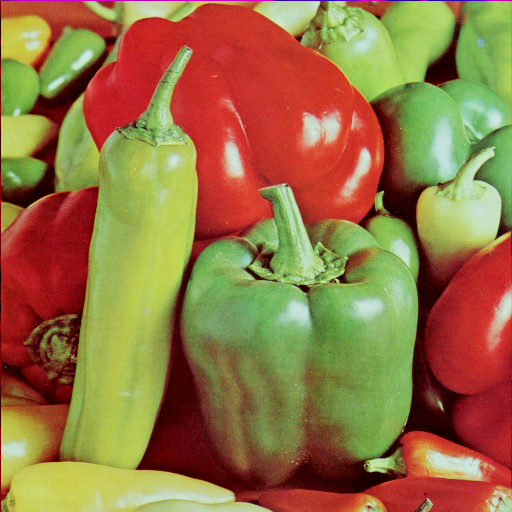

In [32]:
# Load image from disk.
img = Image.open("paprika.tiff")

# Convert to torch tensor.
img_tensor = transforms.ToTensor()(np.array(img))
img

To obtain pixel values for the transformed image grid, we'll use a pytorch function: `grid_sample` function [(link to docs)](https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html). Feel free to go through the docs to understand precisely what this function does, but it should be enough just to know that we use this function for bilinear and trilinear interpolation to obtain kernel weight values for rotated kernel grids.

In [33]:
def bilinear_interpolation(signal, grid):
    """ Obtain signal values for a set of gridpoints through bilinear interpolation.
    
    @param signal: Tensor containing pixel values [C, H, W] or [N, C, H, W]
    @param grid: Tensor containing coordinate values [2, H, W] or [2, N, H, W]
    """
    # If signal or grid is a 3D array, add a dimension to support grid_sample.
    if len(signal.shape) == 3:
        signal = signal.unsqueeze(0)
    if len(grid.shape) == 3:
        grid = grid.unsqueeze(1)
    
    # Grid_sample expects [N, H, W, 2] instead of [2, N, H, W]
    grid = grid.permute(1, 2, 3, 0)
    
    # Grid sample expects YX instead of XY.
    grid = torch.roll(grid, shifts=1, dims=-1)
    
    return torch.nn.functional.grid_sample(
        signal,
        grid,
        padding_mode='zeros',
        align_corners=True,
        mode="bilinear"
    )

def trilinear_interpolation(signal, grid):
    """ 
    
    @param signal: Tensor containing pixel values [C, D, H, W] or [N, C, D, H, W]
    @param grid: Tensor containing coordinate values [3, D, H, W] or [3, N, D, H, W]
    """
    # If signal or grid is a 4D array, add a dimension to support grid_sample.
    if len(signal.shape) == 4:
        signal = signal.unsqueeze(0)
    if len(grid.shape) == 4:
        grid = grid.unsqueeze(1)

    # Grid_sample expects [N, D, H, W, 3] instead of [3, N, D, H, W]
    grid = grid.permute(1, 2, 3, 4, 0)
    
    # Grid sample expects YX instead of XY.
    grid = torch.roll(grid, shifts=1, dims=-1)
    
    return torch.nn.functional.grid_sample(
        signal, 
        grid,
        padding_mode='zeros',
        align_corners=True,
        mode="bilinear" # actually trilinear in this case...
    )


In [34]:
# This creates a grid of the pixel locations in our image of [2, 512, 512] since 
# our image is 2 dimensional and has a width and height of 512 pixels.
img_grid = torch.stack(torch.meshgrid(
    torch.linspace(-1, 1, img_tensor.shape[-2]),
    torch.linspace(-1, 1, img_tensor.shape[-1]),
    indexing='ij'
))

# Let's create the group of 90 degree clockwise rotations.
c4 = CyclicGroup(order=4)
e, g1, g2, _= c4.elements()

# Create a counterclockwise rotation of 270 degrees using only e, g1 and g2.

g3 = c4.product(g1, g2)

assert g3 == c4.elements()[-1]

In [35]:
# Transform the image grid we just created with the matrix representation of 
# this group element.
transformed_img_grid = c4.left_action_on_R2(c4.inverse(g1), img_grid)

# Sample the image on the transformed grid points.
transformed_img = bilinear_interpolation(img_tensor, transformed_img_grid)[0]

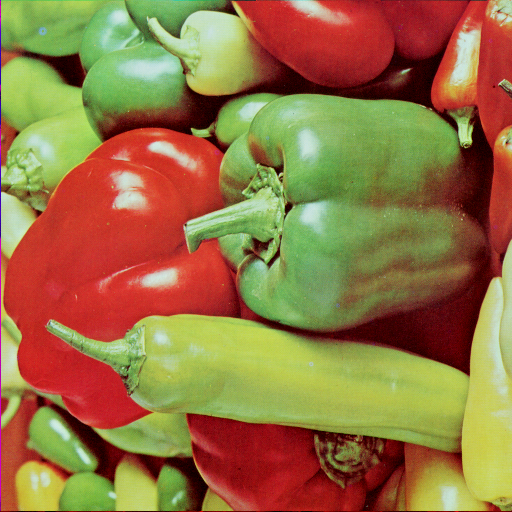

In [36]:
# If we turn this back into a PIL image we can see the result of our transformation!
transforms.ToPILImage()(transformed_img)

## 2. Group Equivariant Convolutional Networks

As discussed in the lecture, regular group convolutional neural networks consist of three main elements. The lifting convolution, group convolution and projection operation. We treat these in order.

### 2.1 Lifting convolution

First is the lifting convolution, which disentangles features at any spatial location in the input $f_{in}$ under transformations of $H$. You may think of this as registering at all locations, for a given feature $e$, the occurrences of transformed versions of this feature $\mathcal{L}_h(e)$, for $h \in H$. (Instead of $\mathcal{L}_h(e)$, we sometimes write $h \cdot e$ to denote the action of $h$ on $e$.) The lifting convolution thus maps from $\mathbb{R}^2$ to $G= \mathbb{R}^2 \rtimes H$. As a result, our lifted feature map $f_{out}$ has, besides the usual spatial dimensions, one or more additional group dimensions (dependent on the dimensionality of $H$).

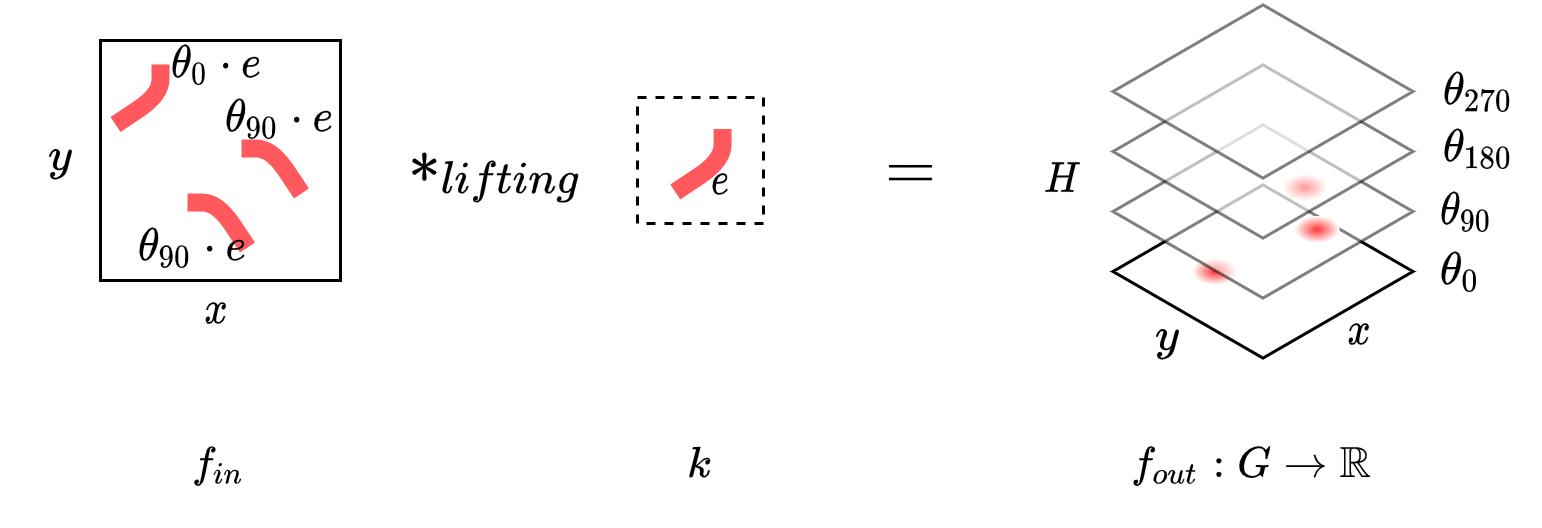

For example, take the group of 90 deg rotations as $H$, and let's say $e$ is a squiggle of sorts, of which we have three occurences in our input feature map $f_{in}$. Two are under a 90 deg rotation; $\theta_{90}\cdot e$, and one is under its canonical orientation; $\theta_0 \cdot e$. A lifting convolution with a kernel $k$ which exactly matches the feature $e$ would land responses at different offsets along the group dimension of the feature map; namely one at the spatial feature map corresponding to the group elements $\theta_0$ and two at the spatial feature map corresponding to $\theta_{90}$. See the above figure for an intuition.

### 2.1.1 Overview

How do we get our convolution operation to pick up features under different transformations of $H$? Intuitively, it is not that different from the convolution operation as we are familiar with in CNNs. There, we enable the extraction of features at any location by sharing the same kernel over all spatial positions.

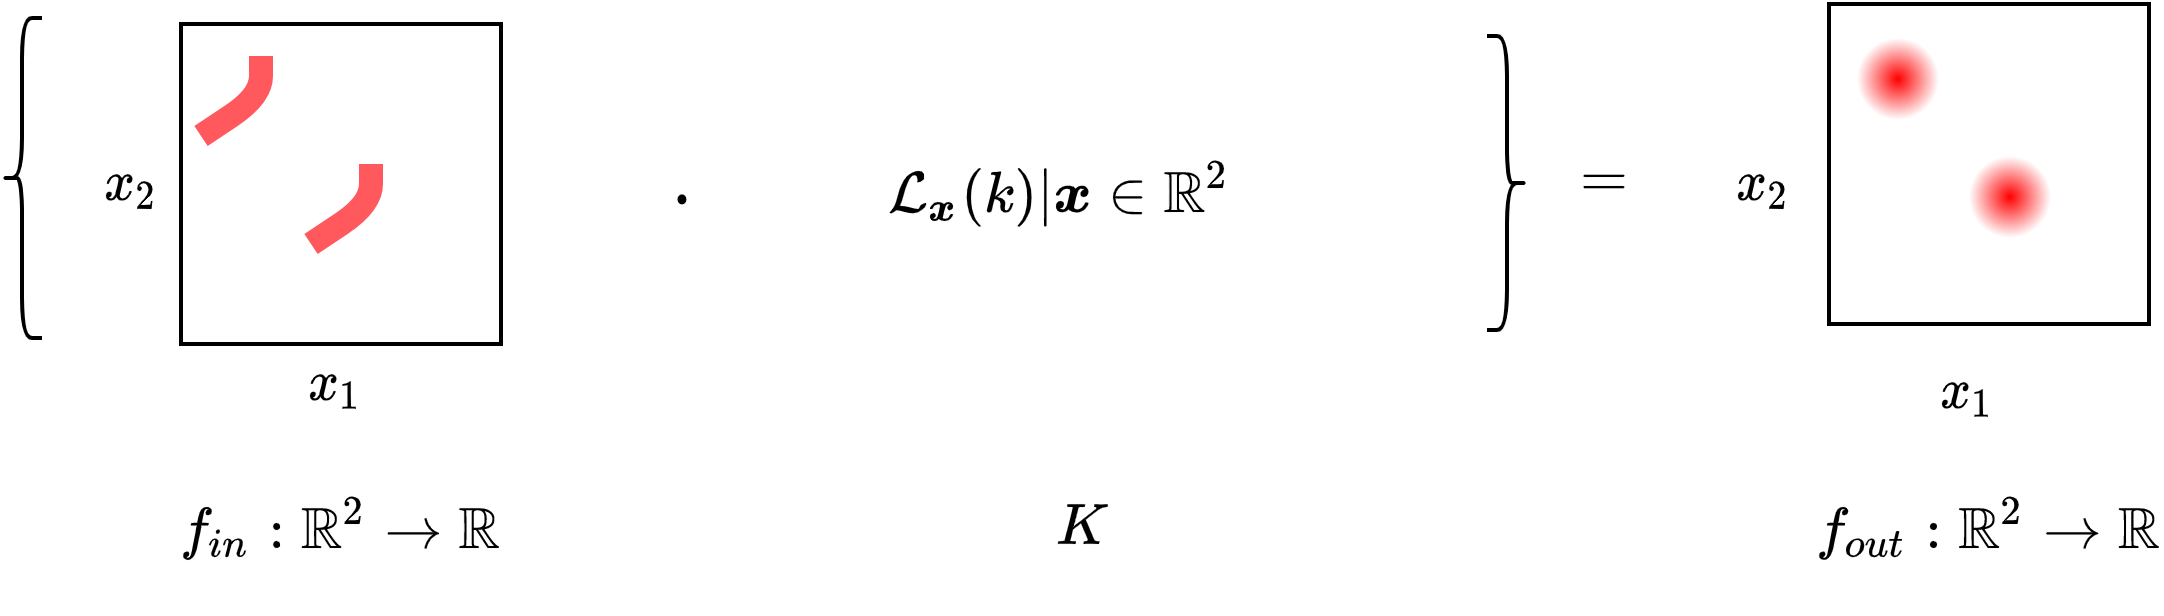


From our current group theoretic perspective, we interpret this as applying all possible translations $\boldsymbol{x} \in \mathbb{R}^2$ to our kernel $k$ and recording the response we get when we take the inner product of the input $f_{in}$ with this transformed kernel $\mathcal{L}_{\mathbf{x}} (k)$. This operation starts with a feature map defined on $\mathbb{R}^2$ and also yields a feature map defined over $\mathbb{R}^2$. See above.



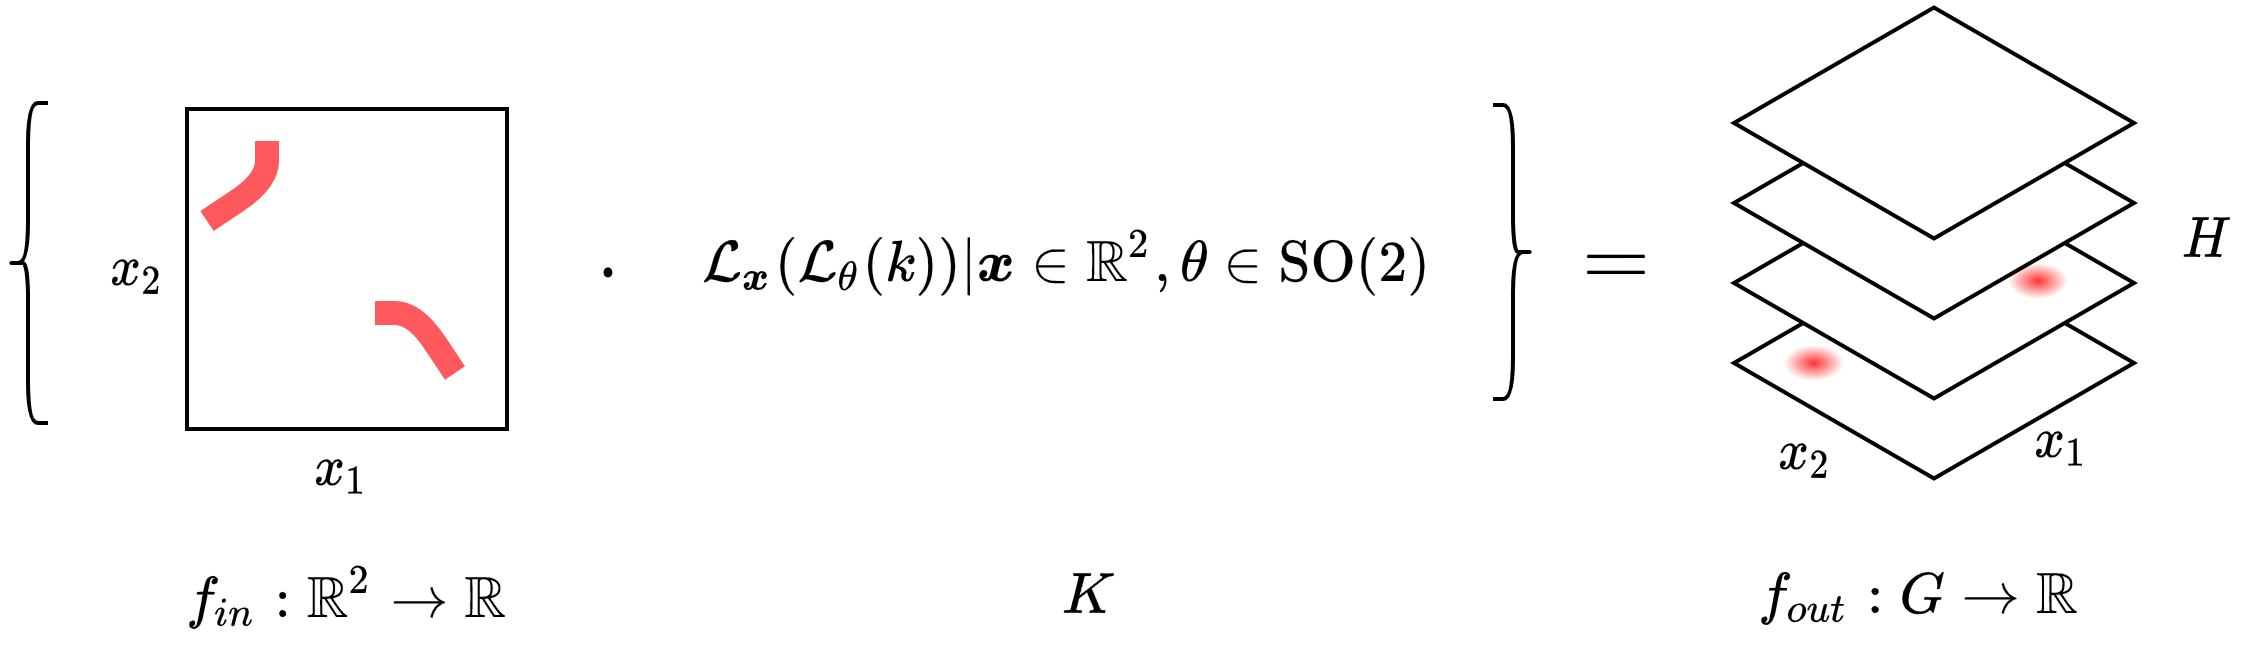

Now that we additionally want to register features under different group actions $\mathcal{L}_h$ for $h \in H$, we can do so by simply *also* transforming $k$ with all of their group actions and recording the results. For example, in case of the rotation group ${\rm C_4}$, we not only translate, but additionally rotate the kernel $k$ by all possible 90 deg rotations, and record the responses for the resulting transformed kernels!

#### 2.1.2 Implementing the lifting convolution kernel

Let's get to programming. First, we need to define a kernel $k$ which we can transform under arbitrary group actions with $\mathcal{L}_h$. When working with images, a convolution kernel is generally defined as a set of independently sampled weights $W$ defined over an equidistant discretisation of $\mathbb{R}^2$ (pixels are evenly spaced).

Recall that we can express the group action of a group $H$ on functions (such as kernels $k$) defined over $\mathbb{R}^2$ through the regular representation $\mathcal{L}_h$. The regular representation transforms the function $k$ through a transformation of the domain of the function $k$. In other words, the regular representation transforms the grid over which the kernel $k$ is defined, to obtain the values for the transformed function $\mathcal{L}_h(k)$.

As such, to define a kernel $k$ which we can transform with the regular representation of a group $H$, we need to construct a grid over which the kernel values are defined. We can then transform this grid by the action of each group element $h \in H$ to obtain a set of grids corresponding to transformed kernels for each of the group elements of $H$.  Let's get to work!

Notes:
*   In implementing the actual lifting and group convolution operations, we will make use of PyTorch's `Conv2D` class. This simplifies our life a lot, since `Conv2D` takes cares of translating the kernels $k$ over all input locations. Hence we do not need to implement the action of the translation group ourselves ($\mathcal{L}_{\mathbf{x}}$), but will still remain translation equivariant! Making our operations compatible with `Conv2D` requires a small amount of trickery, but we will get to that later.

In [37]:
class LiftingKernelBase(torch.nn.Module):
    
    def __init__(self, group, kernel_size, in_channels, out_channels):
        """ Implements a base class for the lifting kernel. Stores the R^2 grid
        over which the lifting kernel is defined and it's transformed copies
        under the action of a group H.
        
        """
        super().__init__()
        self.group = group

        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Create spatial kernel grid. These are the coordinates on which our
        # kernel weights are defined.
        self.register_buffer("grid_R2", torch.stack(torch.meshgrid(
            torch.linspace(-1., 1., self.kernel_size),
            torch.linspace(-1., 1., self.kernel_size),
            indexing='ij'
        )).to(self.group.identity.device))

        # Transform the grid by the elements in this group.
        self.register_buffer("transformed_grid_R2", self.create_transformed_grid_R2())

    def create_transformed_grid_R2(self):
        """Transform the created grid by the group action of each group element.
        This yields a grid (over H) of spatial grids (over R2). In other words,
        a list of grids, each index of which is the original spatial grid transformed by
        a corresponding group element in H.
        
        """
        # Obtain all group elements.

        ## YOUR CODE STARTS HERE ##
        group_elements = self.group.elements()
        ## AND ENDS HERE ##

        # Transform the grid defined over R2 with the sampled group elements.
        # Recall how the left-regular representation acts on the domain of a 
        # function on R2! (Hint: look closely at the equation given under 1.3)
        # We'd like to end up with a grid of shape [2, |H|, kernel_size, kernel_size].

        ## YOUR CODE STARTS HERE ##
        transformed_grids = []
        for element in self.group.inverse(group_elements):
            transformed_grids.append(
                self.group.left_action_on_R2(element, self.grid_R2)
            )
        transformed_grid = torch.stack(transformed_grids, dim=1)
        ## AND ENDS HERE ##

        return transformed_grid


    def sample(self, sampled_group_elements):
        """ Sample convolution kernels for a given number of group elements

        arguments should include:
        :param sampled_group_elements: the group elements over which to sample
            the convolution kernels

        should return:
        :return kernels: filter bank extending over all input channels, 
            containing kernels transformed for all output group elements.
        """
        raise NotImplementedError()


In [38]:
# Let's check whether our implementation works correctly. First we inspect the
# shape of our transformed grids to assess whether this is correct.
order = 4
lifting_kernel_base = LiftingKernelBase(
    group=CyclicGroup(order=order),
    kernel_size=7,
    in_channels=3,
    out_channels=1
)

# The grid has a shape of [2, |H|, kernel_size, kernel_size].
assert lifting_kernel_base.transformed_grid_R2.shape == torch.Size([2, 4, 7, 7])

# Let's print the shapes to see if they are correct. 
# without group
print(lifting_kernel_base.grid_R2.shape)
# with group
print(lifting_kernel_base.transformed_grid_R2.shape)

torch.Size([2, 7, 7])
torch.Size([2, 4, 7, 7])


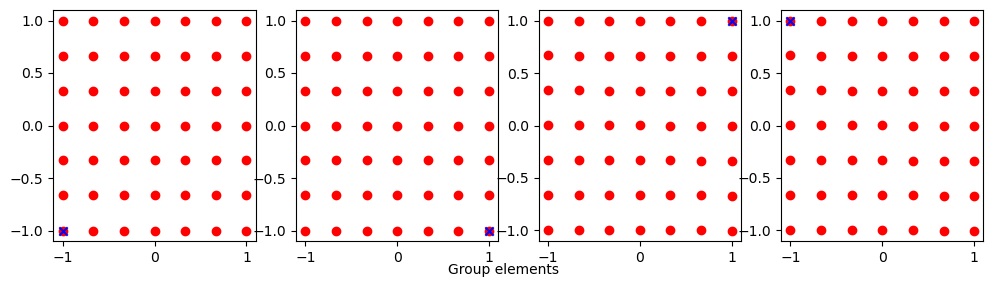

In [39]:
plt.rcParams['figure.figsize'] = [12, 3]

# Create [group_elements] figures
fig, ax = plt.subplots(1, order)

# Get the grid
transformed_grid_R2 = lifting_kernel_base.transformed_grid_R2

# Visualize the transformed kernel grids. We mark the same cornerpoint by a 
# blue 'x' in all grids as reference point.
for group_elem in range(order):
    ax[group_elem].scatter(
        transformed_grid_R2[1, group_elem, :, :],
        transformed_grid_R2[0, group_elem, :, :],
        c='r'
    )
    # Mark a corner point so we can see it transform.
    ax[group_elem].scatter(
        transformed_grid_R2[1, group_elem, 0, 0],
        transformed_grid_R2[0, group_elem, 0, 0],
        marker='x',
        c='b'
    )

fig.text(0.5, 0., 'Group elements', ha='center')
plt.show()

If your code is correctly implemented, you should see the counter-clockwise rotation action happening!

At this point we have a set of grids transformed under the operation of the group $H$. We now need to decide how we are going to sample kernel values at the grid points in each of these grids. This is where the first major hurdle in applying GCNNs occurs.

Whereas conventional CNNs get away with sharing the same set of weights over all spatial positions (which is due to the fact that we translate the kernel only with steps that match whole pixel-distances), for arbitrary groups $H$ we may require kernel values for grid points that lie off the pixel grid of the kernel under its canonical transformation.

Of course, we could (and in fact will) use interpolation to obtain kernel values for grid locations between pixel locations, but this may be limiting in expressivity and will introduce interpolation artefacts!


Notes:

*  When we are implementing equivariance for the group of 90 deg rotations, $H=C_4$, we of course could get away without using interpolation, since all transformed grids lie share the same locations. We could implement the group action of this particular group through a permutation of the weights. But we'd like to be more general than that in this tutorial, so we'll go with interpolation instead! Luckily PyTorch has a function that allows us to sample an input on a grid; we will use PyTorch's `grid_sample` function for interpolation!

In [40]:
class InterpolativeLiftingKernel(LiftingKernelBase):

    def __init__(self, group, kernel_size, in_channels, out_channels):
        super().__init__(group, kernel_size, in_channels, out_channels)

        # Create and initialise a set of weights, we will interpolate these
        # to create our transformed spatial kernels.
        self.weight = torch.nn.Parameter(torch.zeros((
            self.out_channels,
            self.in_channels,
            self.kernel_size,
            self.kernel_size
        ), device=self.group.identity.device))

        # Initialize weights using kaiming uniform intialisation.
        torch.nn.init.kaiming_uniform_(self.weight.data, a=math.sqrt(5))
    
    def sample(self):
        """ Sample convolution kernels for a given number of group elements

        should return:
        :return kernels: filter bank extending over all input channels, 
            containing kernels transformed for all output group elements.
        """
        # First, we fold the output channel dim into the input channel dim; 
        # this allows us to transform the entire filter bank in one go using the
        # torch grid_sample function.

        ## YOUR CODE STARTS HERE ##
        weight = self.weight.view(
            self.out_channels * self.in_channels,
            self.kernel_size,
            self.kernel_size
        )
        ## AND ENDS HERE ##

        # Sample the transformed kernels.
        transformed_weight = []
        for spatial_grid_idx in range(self.group.elements().numel()):
            transformed_weight.append(
                bilinear_interpolation(weight, self.transformed_grid_R2[:, spatial_grid_idx, :, :])
            )
        transformed_weight = torch.stack(transformed_weight)
            
        # Separate input and output channels.
        transformed_weight = transformed_weight.view(
            self.group.elements().numel(),
            self.out_channels,
            self.in_channels,
            self.kernel_size,
            self.kernel_size
        )
        
        # Put out channel dimension before group dimension. We do this
        # to be able to use pytorched Conv2D. Details below!
        transformed_weight = transformed_weight.transpose(0, 1)

        return transformed_weight

In [41]:
ik = InterpolativeLiftingKernel(
    group=CyclicGroup(order=4),
    kernel_size=7,
    in_channels=2,
    out_channels=1
)

weights = ik.sample()
weights.shape

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters in the InterpolativeLiftingKernel: {count_parameters(ik)}")


Number of parameters in the InterpolativeLiftingKernel: 98


Let's visualize the weights we sampled from our lifting convolution kernel!

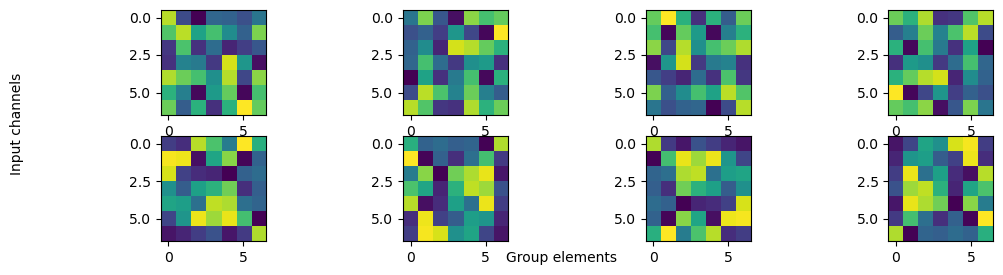

In [42]:
# Pick an output channel to visualize
out_channel_idx = 0

# Create [in_channels, group_elements] figures
fig, ax = plt.subplots(ik.in_channels, ik.group.elements().numel())

for in_channel in range(ik.in_channels):
    for group_elem in range(ik.group.elements().numel()):
        ax[in_channel, group_elem].imshow(
            weights[out_channel_idx, group_elem, in_channel, :, :].detach().numpy()
        )

fig.text(0.5, 0.04, 'Group elements', ha='center')
fig.text(0.04, 0.5, 'Input channels', va='center', rotation='vertical')

plt.show()

As we can see, spatial kernel rotates under the action of the rotation group elements!

#### 2.1.3 Implementing the lifting convolution

Finally, we can implement the lifting convolution operation! This class should take as input a feature map defined over $\mathbb{R}^2$, and spit out a feature map over $\mathbb{R}^2\rtimes H$, where features under different transformations $h \in H$ are disentangled along the $H$ axis!

Notes: 

*  To prevent having to implement our own implementation of the convolution operation, and to leverage the highly optimized pytorch `Conv2D` class, we use some neat tricks in our lifting (and group) convolution classes. Normally, a convolution layer applies a set of $n$ spatial kernels throughout the input, where $n$ is the number of output channels of the convolution operation. Because we now also have `num_group_elem` transformed versions of these kernels, which we want to apply everywhere in the input, we can trick PyTorch by having it treat every transformation of the same spatial kernel as a separate output channel. To do this, we simply reshape our set of `[out_channels, num_group_elem, in_channels, kernel_size, kernel_size]` kernels into a set of  `[out_channels x num_group_elem, in_channels, kernel_size, kernel_size]` kernels. See below!
*   As mentioned, a great additional benefit of using the PyTorch `Conv2D` class is that we are not required to obtain translated kernels $\mathcal{L}_{\mathbf{x}}(k)$ ourselves, PyTorch takes care of that!

In [43]:
class LiftingConvolution(torch.nn.Module):

    def __init__(self, group, in_channels, out_channels, kernel_size, padding):
        super().__init__()

        self.kernel = InterpolativeLiftingKernel(
            group=group,
            kernel_size=kernel_size,
            in_channels=in_channels,
            out_channels=out_channels
        )
        
        self.padding = padding

    def forward(self, x):
        """ Perform lifting convolution

        @param x: Input sample [batch_dim, in_channels, spatial_dim_1, 
            spatial_dim_2]
        @return: Function on a homogeneous space of the group
            [batch_dim, out_channels, num_group_elements, spatial_dim_1, 
            spatial_dim_2]
        """

        # Obtain convolution kernels transformed under the group.
        
        ## YOUR CODE STARTS HERE ##
        conv_kernels = self.kernel.sample()
        ## AND ENDS HERE ##

        # Apply lifting convolution. Note that using a reshape we can fold the
        # group dimension of the kernel into the output channel dimension. We 
        # treat every transformed kernel as an additional output channel. This
        # way we can use pytorch's conv2d function!

        # Question: Do you see why we (can) do this?

        ## YOUR CODE STARTS HERE ##
        x = torch.nn.functional.conv2d(
            input=x,
            weight=conv_kernels.reshape(
                self.kernel.out_channels * self.kernel.group.elements().numel(),
                self.kernel.in_channels,
                self.kernel.kernel_size,
                self.kernel.kernel_size
            ),
            padding=self.padding
        )
        ## AND ENDS HERE ##

        # Reshape [batch_dim, in_channels * num_group_elements, spatial_dim_1, 
        # spatial_dim_2] into [batch_dim, in_channels, num_group_elements, 
        # spatial_dim_1, spatial_dim_2], separating channel and group 
        # dimensions.
        x = x.view(
            -1,
            self.kernel.out_channels,
            self.kernel.group.elements().numel(),
            x.shape[-1],
            x.shape[-2]
        )

        return x


In [44]:
lifting_conv = LiftingConvolution(
    group=CyclicGroup(order=4),
    kernel_size=5,
    in_channels=3,
    out_channels=8,
    padding=False
)

print(f"Number of parameters in the LiftingConvolution: {count_parameters(lifting_conv)}")

Number of parameters in the LiftingConvolution: 600


In [45]:
lifting_conv = LiftingConvolution(
    group=CyclicGroup(order=8),
    kernel_size=5,
    in_channels=3,
    out_channels=8,
    padding=False
)

print(f"Number of parameters in the LiftingConvolution: {count_parameters(lifting_conv)}")

Number of parameters in the LiftingConvolution: 600


### 2.2 Group convolution

Now that we have a way to obtain feature maps defined over the group $G$ from input functions defined over $\mathbb{R}^2$, let's move on to implementing a convolutional layer that fully operates on the group $G: \mathbb{R}^2 \rtimes H$. Note that the input feature map at this stage, $f_{in}$, has, besides the usual spatial dimensions defined over $\mathbb{R}^2$, one or more additional group dimensions defined over $H$. As such, the group convolution operation, $*_{group}$, maps from a function on the group $f_{in}$ to another function on the group $f_{out}$.



#### 2.2.1 Overview

Since the input to the group convolution layer now contains additional group dimensions; $f_{in}: \mathbb{R}^2 \rtimes H \rightarrow \mathbb{R}$, we need to convolve it with a kernel $k_{group}$ that is also defined over the entire group; $k_{group}: \mathbb{R}^2 \rtimes H \rightarrow \mathbb{R}$. This is in contrast to the lifting convolution, where $k_{lifting}$ was only defined over the spatial domain $\mathbb{R}^2$. You could think of this kernel $k_{group}$ as a stack of spatial kernels, a separate one for each group element $h \in H$. Importantly, since $k$ is now *also* defined on a grid over $H$, the group $H$ now also has an action *on* this $H$-axis of $k$. For example, in our case of $H=C_4$, elements $\theta \in C_4$ now not only have a rotating action on the spatial domain of the kernel, but also a translating action along the group axis. Hence, applying a group element $\theta \in C_4$ leads to a twist-shift of the $k$ along the group axis. See below! (Remember $H=C_4$ is periodic)



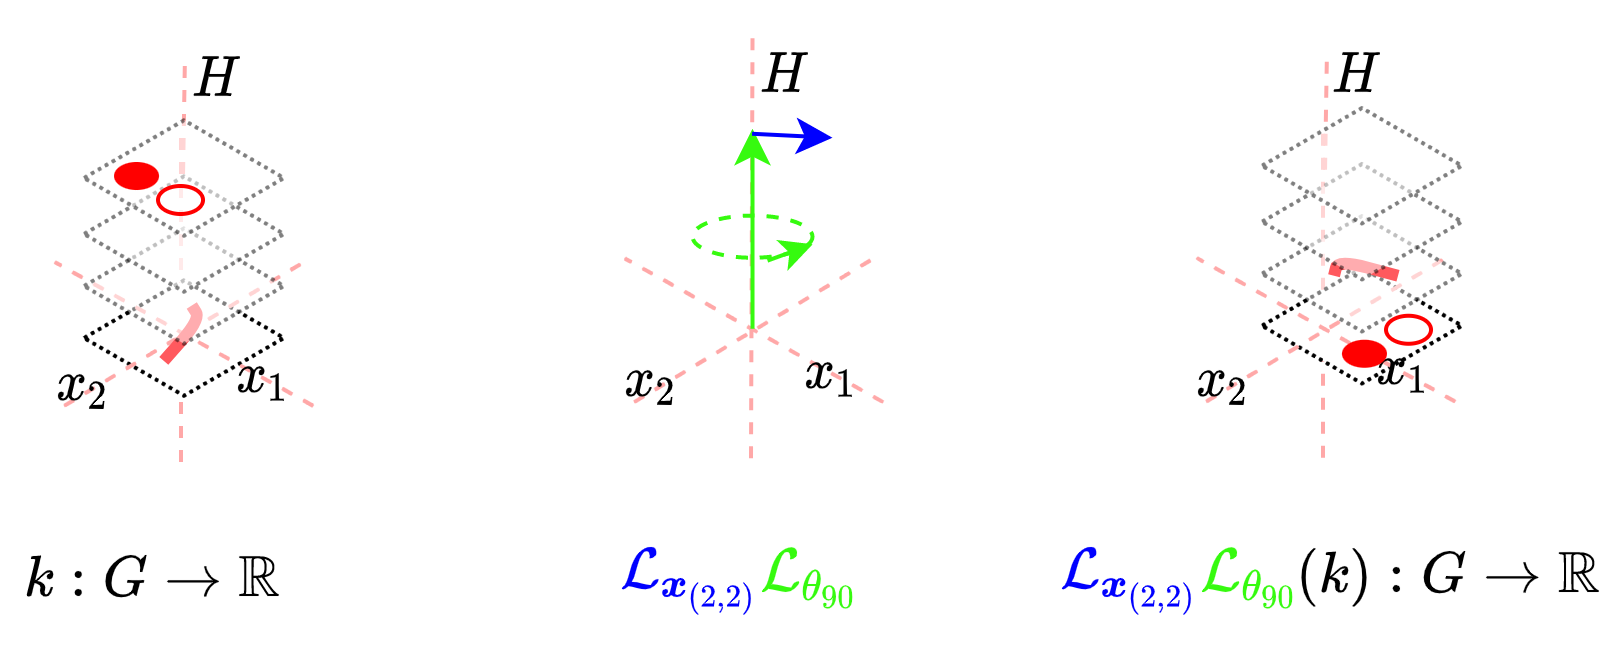


Apart from this difference, the group convolution operator works in much the same way as the liting operator. We again transform the kernel $k_{group}$ with the actions of the group $H$ and $\mathbb{R}^2$ and obtain responses for the inner product of this kernel with the input (although again, we let PyTorch do all the work for the translation group). See below for an intuition.


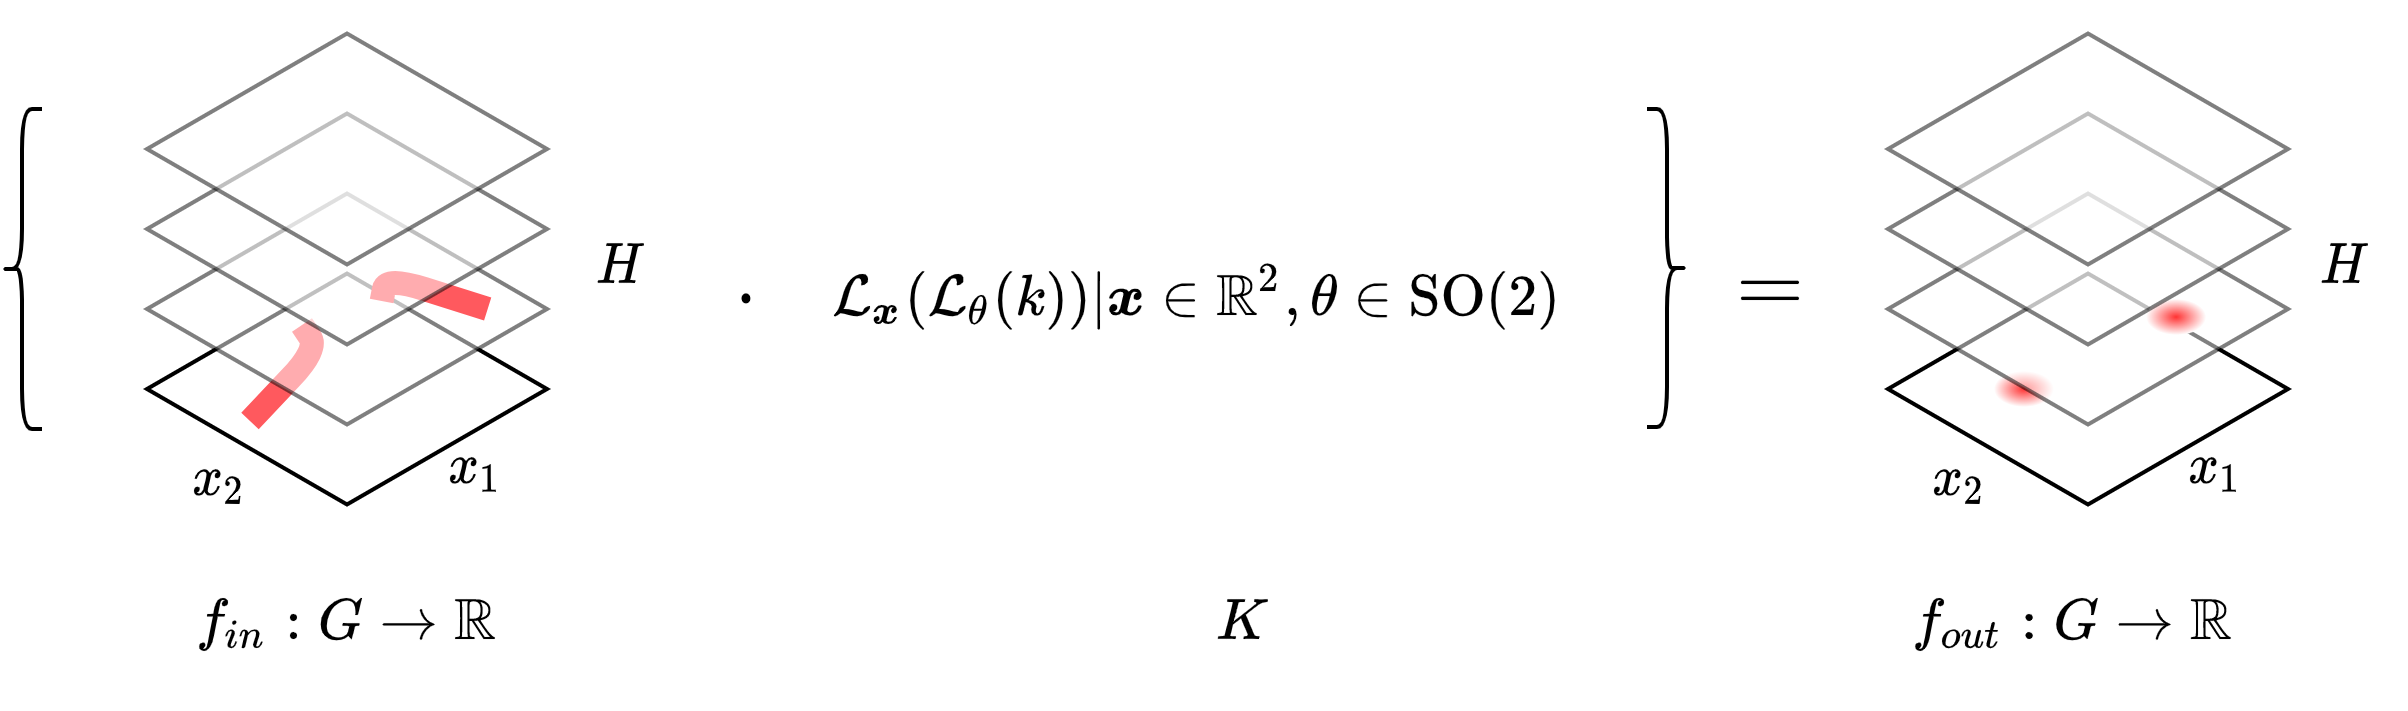

#### 2.2.2 Implementing the group convolution kernel

Again, let's define a kernel $k$ which we can transform with the group action. Now, our kernel grid is not only defined over $\mathbb{R}^2$, but additionally over $H$.

Notes:

*   Since the grid over $H$ is made up of elements $h'\in H$, transforming the grid over $H$ with (another) group element $h \in H$ comes out to applying the group product of $h$ with each grid element $h'$.
*   Because we are working with semidirect product groups $\mathbb{R}^2 \rtimes H$, we can transform the $\mathbb{R}^2$ and $H$ dimensions of our grids separately before combining them into a shared grid over $\mathbb{R}^2 \rtimes H$!

In [46]:
class GroupKernelBase(torch.nn.Module):

    def __init__(self, group, kernel_size, in_channels, out_channels):
        """ Implements base class for the group convolution kernel. Stores grid
        defined over the group R^2 \rtimes H and it's transformed copies under
        all elements of the group H.
        
        """
        super().__init__()
        self.group = group

        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels

        # Create a spatial kernel grid
        self.register_buffer("grid_R2", torch.stack(torch.meshgrid(
            torch.linspace(-1., 1., self.kernel_size),
            torch.linspace(-1., 1., self.kernel_size),
            indexing='ij'
        )).to(self.group.identity.device))

        # The kernel grid now also extends over the group H, as our input 
        # feature maps contain an additional group dimension
        self.register_buffer("grid_H", self.group.elements())
        self.register_buffer("transformed_grid_R2xH", self.create_transformed_grid_R2xH())

    def create_transformed_grid_R2xH(self):
        """Transform the created grid over R^2 \rtimes H by the group action of 
        each group element in H.
        
        This yields a set of grids over the group. In other words, a list of 
        grids, each index of which is the original grid over G transformed by
        a corresponding group element in H.
        """
        # Sample the group H.
        
        ## YOUR CODE STARTS HERE ##
        group_elements = self.group.elements()
        ## AND ENDS HERE ##

        # Transform the grid defined over R2 with the sampled group elements.
        # We again would like to end up with a grid of shape [2, |H|, kernel_size, kernel_size].
        
        ## YOUR CODE STARTS HERE ##
        transformed_grid_R2 = []
        for g_inverse in self.group.inverse(group_elements):
            transformed_grid_R2.append(
                self.group.left_action_on_R2(g_inverse, self.grid_R2)
            )
        transformed_grid_R2 = torch.stack(transformed_grid_R2, dim=1)
        ## AND ENDS HERE ##

        # Transform the grid defined over H with the sampled group elements. We want a grid of 
        # shape [|H|, |H|]. Make sure to stack the transformed like above (over the 1st dim).

        ## YOUR CODE STARTS HERE ##
        transformed_grid_H = []
        for g_inverse in self.group.inverse(group_elements):
            transformed_grid_H.append(
                self.group.product(
                    g_inverse, self.grid_H
                )
            )
        transformed_grid_H = torch.stack(transformed_grid_H, dim=1)
        ## AND ENDS HERE ##

        # Rescale values to between -1 and 1, we do this to please the torch
        # grid_sample function.
        transformed_grid_H = self.group.normalize_group_elements(transformed_grid_H)

        # Create a combined grid as the product of the grids over R2 and H
        # repeat R2 along the group dimension, and repeat H along the spatial dimension
        # to create a [3, |H|, |H|, kernel_size, kernel_size] grid
        transformed_grid = torch.cat(
            (
                transformed_grid_R2.view(
                    2,
                    group_elements.numel(),
                    1,
                    self.kernel_size,
                    self.kernel_size,
                ).repeat(1, 1, group_elements.numel(), 1, 1),
                transformed_grid_H.view(
                    1,
                    group_elements.numel(),
                    group_elements.numel(),
                    1,
                    1,
                ).repeat(1, 1, 1, self.kernel_size, self.kernel_size)
            ),
            dim=0
        )
        return transformed_grid


    def sample(self, sampled_group_elements):
        """ Sample convolution kernels for a given number of group elements

        arguments should include:
        :param sampled_group_elements: the group elements over which to sample
            the convolution kernels

        should return:
        :return kernels: filter bank extending over all input channels, 
            containing kernels transformed for all output group elements.
        """
        raise NotImplementedError()

Let's get some intuition for what is happening with our grid when we apply the group action of $H$ to it. First we will inspect the action on $\mathbb{R}^2$.

In our current setting, $H$ is one-dimensional, and as we can see, transforming the grid over $H$ with all group elements of $H$ leads to a translation over the group. Next, let's see what happens when we combine these grids.

In [47]:
gk_base = GroupKernelBase(
    group=CyclicGroup(order=4),
    kernel_size=7,
    in_channels=1,
    out_channels=1
)

gk_base.transformed_grid_R2xH.shape

torch.Size([3, 4, 4, 7, 7])

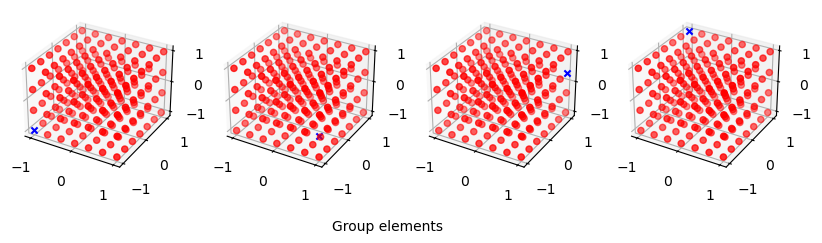

In [48]:
plt.rcParams['figure.figsize'] = [10, 3]

# Create [group_elements] figures.
fig, ax = plt.subplots(
    1,
    gk_base.group.elements().numel(),
    subplot_kw=dict(projection='3d')
)

# Flatten spatial and group grid dimensions.
transformed_grid_R2xH = gk_base.transformed_grid_R2xH.reshape(
    3, 
    gk_base.group.elements().numel(),
    gk_base.group.elements().numel() * gk_base.kernel_size * gk_base.kernel_size
)

# Visualize the transformed kernel grids. We mark the same row by a blue 'x' in all grids as reference point.
for group_elem in range(gk_base.group.elements().numel()):
    ax[group_elem].scatter(transformed_grid_R2xH[1, group_elem, 1:],
                           transformed_grid_R2xH[0, group_elem, 1:],
                           transformed_grid_R2xH[2, group_elem, 1:],
                           c='r')
    ax[group_elem].scatter(transformed_grid_R2xH[1, group_elem, 0],
                           transformed_grid_R2xH[0, group_elem, 0],
                           transformed_grid_R2xH[2, group_elem, 0],
                           marker='x',
                           c='b')

fig.text(0.5, 0.04, 'Group elements', ha='center')

plt.show()

As we can see, under the application of group elements $h' \in H$ the grid defined over $\mathbb{R}^2 \rtimes H$ rotates over the spatial dimensions, and shifts along the group dimension!

Let's now implement the group kernel using interpolation as well.

Notes:
*   For multidimensional groups $H$ the following implementation won't work, as this would require kernels defined on grids with dimensionality > 3, which our implementation of trilinear interpolation with `grid_sample` does not support. To resolve this, one could implement the sampling of the weights along the $H$ dimension using a translation of the weight matrix along the $H$ dimensions, and only interpolate over the spatial dimensions. This is possible because we don't end up between grid points along the group dimension $H$ (remember the closure constraint of the group product?).
*   The $C_4$ group exhibits periodicity along the group axis, so our kernels should too. Although we correctly implemented the group product to reflect this, `grid_sample` doesn't know about the periodicity of the weights in its interpolation. This shouldn't be a problem since, again because of the closure constraint, we should always end up exactly on grid points along the group axis, meaning no interpolation is necessary in that direction. In practice, because of the way `grid_sample` is implemented, we may encounter some small interpolation artefacts because of this.

In [49]:
class InterpolativeGroupKernel(GroupKernelBase):

    def __init__(self, group, kernel_size, in_channels, out_channels):
        super().__init__(group, kernel_size, in_channels, out_channels)

        # create and initialise a set of weights, we will interpolate these
        # to create our transformed spatial kernels. Note that our weight
        # now also extends over the group H.

        ## YOUR CODE STARTS HERE ##
        self.weight = torch.nn.Parameter(torch.zeros((
            self.out_channels,
            self.in_channels,
            self.group.elements().numel(), # this is different from the lifting convolution
            self.kernel_size,
            self.kernel_size
        ), device=self.group.identity.device))
        ## AND ENDS HERE ##

        # initialize weights using kaiming uniform intialisation.
        torch.nn.init.kaiming_uniform_(self.weight.data, a=math.sqrt(5))
    
    def sample(self):
        """ Sample convolution kernels for a given number of group elements

        should return:
        :return kernels: filter bank extending over all input channels, 
            containing kernels transformed for all output group elements.
        """
        # First, we fold the output channel dim into the input channel dim; 
        # this allows us to transform the entire filter bank in one go using the
        # interpolation function.
       
        ## YOUR CODE STARTS HERE ##
        weight = self.weight.view(
            self.out_channels * self.in_channels,
            self.group.elements().numel(),
            self.kernel_size,
            self.kernel_size
        )
        ## AND ENDS HERE ## 
        
        transformed_weight = []
        # We loop over all group elements and retrieve weight values for
        # the corresponding transformed grids over R2xH.
        for grid_idx in range(self.group.elements().numel()):
            transformed_weight.append(
                trilinear_interpolation(weight, self.transformed_grid_R2xH[:, grid_idx, :, :, :])
            )
        transformed_weight = torch.stack(transformed_weight)
        
        # Separate input and output channels.
        transformed_weight = transformed_weight.view(
            self.group.elements().numel(),
            self.out_channels,
            self.in_channels,
            self.group.elements().numel(),
            self.kernel_size,
            self.kernel_size
        )

        # Put out channel dimension before group dimension. We do this
        # to be able to use pytorched Conv2D. Details below!
        transformed_weight = transformed_weight.transpose(0, 1)
        
        return transformed_weight

In [50]:
igk = InterpolativeGroupKernel(
    group=CyclicGroup(order=4),
    kernel_size=5,
    in_channels=2,
    out_channels=8
)

In [51]:
weights = igk.sample()
weights.shape

torch.Size([8, 4, 2, 4, 5, 5])

Let's visualize the sampled group convolution kernels! We visualize our 3D kernels in 2D by folding the input group dimension into the first spatial dimension. In doing so, we create a 2D flattened version of the 3D group convolution kernel, where spatial kernels corresponding to the different group elements lie along the spatial dimension. Each channel goes from `[num_group_elem, kernel_size, kernel_size]` to `[num_group_elem x kernel_size, kernel_size]`.

To clearly see what happens to the group convolution kernel under transformation of the group $H$, we outline the spatial kernel corresponding to the first input group element in red. For subsequent transformations we can see this spatial kernel. See below!

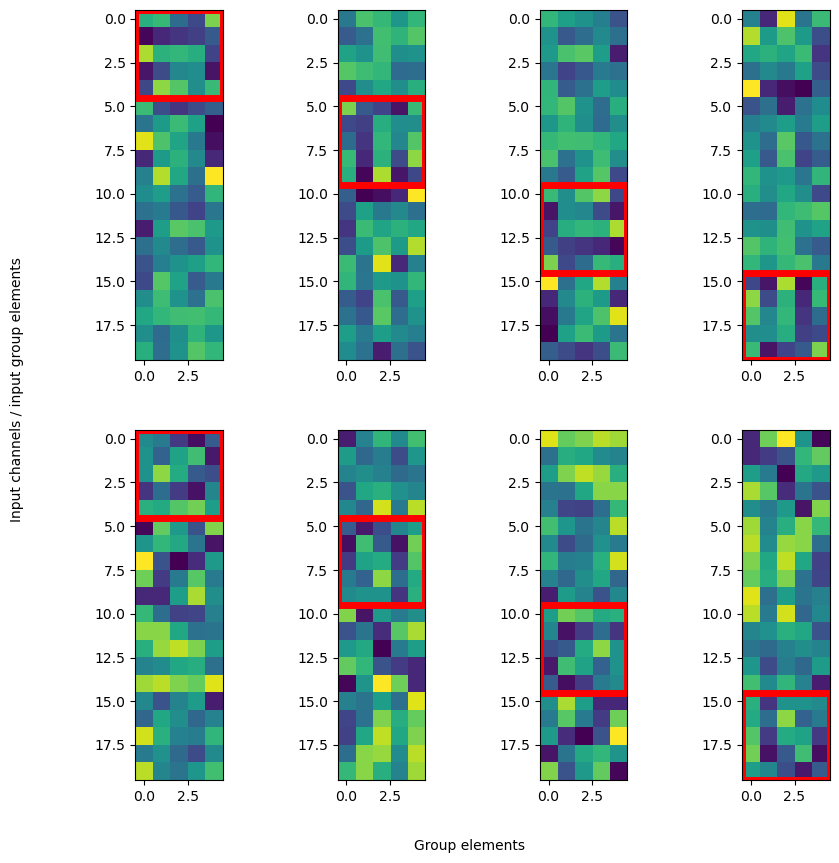

In [52]:
plt.rcParams['figure.figsize'] = [10, 10]

# For ease of viewing, we fold the input group dimension into the spatial x dimension
weights_t = weights.view(
    igk.out_channels,
    igk.group.elements().numel(),
    igk.in_channels,
    igk.group.elements().numel() * igk.kernel_size,
    igk.kernel_size
)

# pick an output channel to visualize
out_channel_idx = 0

# create [in_channels, group_elements] figures
fig, ax = plt.subplots(igk.in_channels, igk.group.elements().numel())

for in_channel in range(igk.in_channels):
    for group_elem in range(igk.group.elements().numel()):
        ax[in_channel, group_elem].imshow(
            weights_t[out_channel_idx, group_elem, in_channel, :, :].detach()
        )

        # Outline the spatial kernel corresponding to the first group element under canonical transformation
        rect = matplotlib.patches.Rectangle(
            (-0.5, group_elem * weights_t.shape[-1] - 0.5), weights_t.shape[-1], weights_t.shape[-1], linewidth=5, edgecolor='r', facecolor='none')
        ax[in_channel, group_elem].add_patch(rect)

fig.text(0.5, 0.04, 'Group elements', ha='center')
fig.text(0.04, 0.5, 'Input channels / input group elements', va='center', rotation='vertical')

plt.show()

We see the same twist shift motion as we saw with the kernel grids!

#### 2.2.3 Implementing the group convolution

The next step is implementing the group convolution operation. 

Notes:
*  We would still like to use PyTorch's `Conv2D` implementation, but we're now faced with an additional problem; the group dimension in the input feature map. Luckily we can resolve this problem in much the same way; normally a 2D convolution layer integrates over a local neighbourhood of all input channels. We would now additionally like to integrate over the entire group. Thus, we can simply treat the group dimensions in the input feature map as additional channel dimensions! We achieve this by folding our input group dimension into the input channel dimension; $f_{in}$ is reshaped from `[batch, in_channels, num_group_elem, spatial_1, spatial_2]` into `[batch, in_channels x num_group_elem, spatial_1, spatial_2]`.
*  To match this, and to apply the same trick as we did in the lifting convolution to get results for each separate group element in the *output*, we also reshape our kernel from `[out_channels, num_group_elem, in_channels, num_group_elem, kernel_size, kernel_size]` to `[out_channels x num_group_elem, in_channels x num_group_elem, kernel_size, kernel_size]`. See below!

In [53]:
class GroupConvolution(torch.nn.Module):

    def __init__(self, group, in_channels, out_channels, kernel_size, padding):
        super().__init__()

        self.kernel = InterpolativeGroupKernel(
            group=group,
            kernel_size=kernel_size,
            in_channels=in_channels,
            out_channels=out_channels
        )
        
        self.padding = padding
        

    def forward(self, x):
        """ Perform lifting convolution

        @param x: Input sample [batch_dim, in_channels, group_dim, spatial_dim_1, 
            spatial_dim_2]
        @return: Function on a homogeneous space of the group
            [batch_dim, out_channels, num_group_elements, spatial_dim_1, 
            spatial_dim_2]
        """

        # We now fold the group dimensions of our input into the input channel
        # dimension.

        ## YOUR CODE STARTS HERE ##
        x = x.reshape(
            -1,
            x.shape[1] * x.shape[2],
            x.shape[3],
            x.shape[4]
        )
        ## AND ENDS HERE ##

        # We obtain convolution kernels transformed under the group.

        ## YOUR CODE STARTS HERE ##
        conv_kernels = self.kernel.sample()
        ## AND ENDS HERE ##

        # Apply group convolution, note that the reshape folds the 'output' group 
        # dimension of the kernel into the output channel dimension, and the 
        # 'input' group dimension into the input channel dimension.

        # Question: Do you see why we (can) do this?

        ## YOUR CODE STARTS HERE ##
        x = torch.nn.functional.conv2d(
            input=x,
            weight=conv_kernels.reshape(
                self.kernel.out_channels * self.kernel.group.elements().numel(),
                self.kernel.in_channels * self.kernel.group.elements().numel(),
                self.kernel.kernel_size,
                self.kernel.kernel_size
            ),
            padding=self.padding
        )
        ## AND ENDS HERE ##

        # Reshape [batch_dim, in_channels * num_group_elements, spatial_dim_1, 
        # spatial_dim_2] into [batch_dim, in_channels, num_group_elements, 
        # spatial_dim_1, spatial_dim_2], separating channel and group 
        # dimensions.
        x = x.view(
            -1,
            self.kernel.out_channels,
            self.kernel.group.elements().numel(),
            x.shape[-1],
            x.shape[-2],
        )

        return x


### 2.3 Projection to obtain invariance and tying everything together

Up until now, our feature maps equivary with the group action of $\mathbb{R}^2 \rtimes H$; our feature maps are defined over $\mathbb{R}^2 \rtimes H$. Usually in a CNN, a series of convolutional layers build a representation, which is followed by a (number of) linear layer(s). To create a GCNN using our lifting and group convolution operations that is fully invariant to the action of the group, we must apply a projection operation invariant to the action of the group to our feature map, to reduce its dimensionality from `[batch, channels, num_group_elem, spatial_1, spatial_2]` to `[batch, channels]` or even . The representation that we obtain then is fully invariant to the group. This representation is pushed through a final linear layer to yield a classification.

Below, we build a small GCNN from our implemented PyTorch modules.

Notes:
*   We use a mean-pooling operation to pool over group and spatial dimensions, but we could also use max or min pooling, or any other operation invariant to the group.

In [54]:
from torch.nn import AdaptiveAvgPool3d


class GroupEquivariantCNN(torch.nn.Module):

    def __init__(self, group, in_channels, out_channels, kernel_size, num_hidden, hidden_channels):
        super().__init__()

        # Create the lifing convolution.

        ## YOUR CODE STARTS HERE ##
        self.lifting_conv = LiftingConvolution(
            group=group,
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size,
            padding=0
        )
        ## AND ENDS HERE ##

        # Create a set of group convolutions.
        self.gconvs = torch.nn.ModuleList()

        ## YOUR CODE STARTS HERE ##
        for i in range(num_hidden):
            self.gconvs.append(
                GroupConvolution(
                    group=group,
                    in_channels=hidden_channels,
                    out_channels=hidden_channels,
                    kernel_size=kernel_size,
                    padding=0
                )
            )
        ## AND ENDS HERE ##

        # Create the projection layer. Hint: check the import at the top of
        # this cell.
        
        ## YOUR CODE STARTS HERE ##
        self.projection_layer = torch.nn.AdaptiveAvgPool3d(1)
        ## AND ENDS HERE ##

        # And a final linear layer for classification.
        self.final_linear = torch.nn.Linear(hidden_channels, out_channels)
    
    def forward(self, x):
        
        # Lift and disentangle features in the input.
        x = self.lifting_conv(x)
        x = torch.nn.functional.layer_norm(x, x.shape[-4:])
        x = torch.nn.functional.relu(x)

        # Apply group convolutions.
        for gconv in self.gconvs:
            x = gconv(x)
            x = torch.nn.functional.layer_norm(x, x.shape[-4:])
            x = torch.nn.functional.relu(x)
        
        # to ensure equivariance, apply max pooling over group and spatial dims.
        x = self.projection_layer(x).squeeze()

        x = self.final_linear(x)
        return x

To compare, let's create a more or less identical CNN. The only difference here is that this network consists of regular convolution operations.

In [55]:
class CNN(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, num_hidden, hidden_channels):
        super().__init__()

        self.first_conv = torch.nn.Conv2d(
            in_channels=in_channels,
            out_channels=hidden_channels,
            kernel_size=kernel_size,
            padding=0
        )

        self.convs = torch.nn.ModuleList()
        for i in range(num_hidden):
            self.convs.append(
                torch.nn.Conv2d(
                    in_channels=hidden_channels,
                    out_channels=hidden_channels,
                    kernel_size=kernel_size,
                    padding=0
                )
            )

        self.final_linear = torch.nn.Linear(hidden_channels, out_channels)
    
    def forward(self, x):

        x = self.first_conv(x)
        x = torch.nn.functional.layer_norm(x, x.shape[-3:])
        x = torch.nn.functional.relu(x)

        for conv in self.convs:
            x = conv(x)
            x = torch.nn.functional.layer_norm(x, x.shape[-3:])
            x = torch.nn.functional.relu(x)
        
        # Apply average pooling over remaining spatial dimensions.
        x = torch.nn.functional.adaptive_avg_pool2d(x, 1).squeeze()

        x = self.final_linear(x)
        return x

## 3. Experimenting with our implementation

Note that for ease of model training and tracking, we additionally make use of `pytorch-lightning`. Although the specifics of this package aren't the focus of this tutorial, if you'd like a refresher please have a look at this excellent [Deep Learning 1 tutorial by Phillip Lippe](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html#PyTorch-Lightning).



### 3.1 Generalization to the group action

To show the generalization capabilities of regular group convolutional networks, we will train this model on the MNIST training dataset, but evaluate it on an augmented version of the MNIST test set in which each image is randomly rotated by a continuous rotation between $[0, 2\pi]$.

In [56]:
# We normalize the training data.
train_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                                  ])

# To demonstrate the generalization capabilities our rotation equivariant layers bring, we apply a random
# rotation between 0 and 360 deg to the test set.
test_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.RandomRotation(
                                                     [0, 360],
                                                     torchvision.transforms.InterpolationMode.BILINEAR,
                                                     fill=0),
                                                 torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                                 ])

# We demonstrate our models on the MNIST dataset.
train_ds = torchvision.datasets.MNIST(root=DATASET_PATH, train=True, transform=train_transform, download=True)
test_ds = torchvision.datasets.MNIST(root=DATASET_PATH, train=False, transform=test_transform)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)

# Set the random seed for reproducibility.
pl.seed_everything(12)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 10.4MB/s]


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 265kB/s]


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 1.79MB/s]


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.43MB/s]
Seed set to 12


Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



12

Let's visualize some of the training and test images. As we can see the test images are randomly rotated.

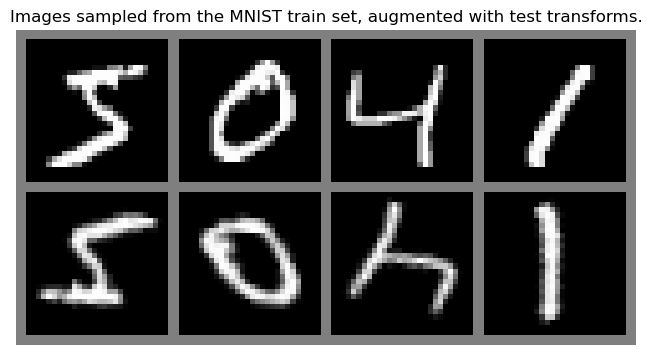

In [57]:
NUM_IMAGES = 4
images = [train_ds[idx][0] for idx in range(NUM_IMAGES)]
orig_images = [Image.fromarray(train_ds.data[idx].numpy()) for idx in range(NUM_IMAGES)]
orig_images = [test_transform(img) for img in orig_images]

img_grid = torchvision.utils.make_grid(torch.stack(images + orig_images, dim=0), nrow=4, normalize=True, pad_value=0.5)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Images sampled from the MNIST train set, augmented with test transforms.")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [58]:
class DataModule(pl.LightningModule):

    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        """
        Inputs:
            model_name - Name of the model/CNN to run. Used for creating the model (see function below)
            model_hparams - Hyperparameters for the model, as dictionary.
            optimizer_name - Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams - Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
        """
        super().__init__()
        # Exports the hyperparameters to a YAML file, and create "self.hparams" namespace
        self.save_hyperparameters()
        # Create model
        self.model = create_model(model_name, model_hparams)
        # Create loss module
        self.loss_module = nn.CrossEntropyLoss()

    def forward(self, imgs):
        return self.model(imgs)

    def configure_optimizers(self):
        # AdamW is Adam with a correct implementation of weight decay (see here for details: https://arxiv.org/pdf/1711.05101.pdf)
        optimizer = optim.AdamW(
            self.parameters(), **self.hparams.optimizer_hparams)
        return [optimizer], []

    def training_step(self, batch, batch_idx):
        # "batch" is the output of the training data loader.
        imgs, labels = batch
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logs the accuracy per epoch to tensorboard (weighted average over batches)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss)
        return loss  # Return tensor to call ".backward" on

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        # By default logs it per epoch (weighted average over batches), and returns it afterwards
        self.log('test_acc', acc, prog_bar=True)

We create a dictionary to keep track of our models

In [59]:
model_dict = {
    'CNN': CNN,
    'GCNN': GroupEquivariantCNN
}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f"Unknown model name \"{model_name}\". Available models are: {str(model_dict.keys())}"

In [60]:
def train_model(model_name, save_name=None, **kwargs):
    """
    Inputs:
        model_name - Name of the model you want to run. Is used to look up the class in "model_dict"
        save_name (optional) - If specified, this name will be used for creating the checkpoint and logging directory.
    """
    if save_name is None:
        save_name = model_name

    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, save_name),                          # Where to save models
                         accelerator='auto',                                             # We run on a single GPU (if possible)
                         max_epochs=10,                                                                      # How many epochs to train for if no patience is set
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),  # Save the best checkpoint based on the maximum val_acc recorded. Saves only weights and not optimizer
                                    LearningRateMonitor("epoch")])
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, save_name + ".ckpt")
    
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = DataModule.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(12) # To be reproducable
        model = DataModule(model_name=model_name, **kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = DataModule.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on test set
    val_result = trainer.test(model.to(device), test_loader, verbose=False)
    result = {"val": val_result[0]["test_acc"]}

    return model, result

Let's train the conventional CNN first!

In [61]:
cnn_model, cnn_results = train_model(model_name="CNN",
                                     model_hparams={"in_channels": 1,
                                                    "out_channels": 10,
                                                    "kernel_size": 5,
                                                    "num_hidden":4,
                                                    "hidden_channels":32},
                                     optimizer_name="Adam",
                                     optimizer_hparams={"lr": 1e-2,
                                                        "weight_decay": 1e-4},
                                     save_name='cnn-pretrained')

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/trinci/miniconda3/envs/group_cov/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Seed set to 12
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/trinci/miniconda3/envs/group_cov/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/trinci/miniconda3/envs/group_cov/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 938/938 [00:18<00:00, 51.77it/s, v_num=0, val_acc=0.496]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 938/938 [00:18<00:00, 51.49it/s, v_num=0, val_acc=0.496]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/trinci/miniconda3/envs/group_cov/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 157/157 [00:03<00:00, 42.19it/s]


Next, we train the GCNN. Note that we reduce the number of channels by half to account for the increased kernel dimensionality. We do this to keep the number of trainable parameters more or less equal.

In [36]:
gcnn_model, gcnn_results = train_model(model_name="GCNN",
                                       model_hparams={"in_channels": 1,
                                                      "out_channels": 10,
                                                      "kernel_size": 5,
                                                      "num_hidden": 4,
                                                      "hidden_channels":16, # to account for the increase in trainable parameters due to the extra dimension in our feature maps, remove some hidden channels.
                                                      "group":CyclicGroup(order=4).to(device)},
                                       optimizer_name="Adam",
                                       optimizer_hparams={"lr": 1e-2,
                                                          "weight_decay": 1e-4},
                                       save_name='gcnn-pretrained')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 12
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/davidknigge/anaconda3/envs/dl2/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ../../saved_models/DL2/GDL/gcnn-pretrained/lightning_logs/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                | Params
--------------------------------------

Epoch 0: 100%|███████████████████████| 938/938 [00:14<00:00, 66.83it/s, v_num=0]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|████████| 938/938 [00:13<00:00, 67.89it/s, v_num=0, val_acc=0.585]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|████████| 938/938 [00:13<00:00, 67.53it/s, v_num=0, val_acc=0.779]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|████████| 938/938 [00:13<00:00, 67.24it/s, v_num=0, val_acc=0.820]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|████████| 938/938 [00:13<00:00, 68.73it/s, v_num=0, val_acc=0.875]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|████████| 938/938 [00:13<00:00, 67.04it/s, v_num=0, val_acc=0.884]
Validation: 0it [00:00, ?it/s]
Epoch 6: 100%|████████| 938/938 [00:14<00:00, 66.64it/s, v_num=0, val_acc=0.886]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|████████| 938/938 [00:14<00:00, 65.80it/s, v_num=0, val_acc=0.864]
Validation: 0it [00:00, ?it/s]
Epoch 8: 100%|████████| 938/938 [00:14<00:00, 66.75it/s, v_num=0, val_acc=0.905]
Validation: 0it [00:00,

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████| 938/938 [00:17<00:00, 53.07it/s, v_num=0, val_acc=0.898]


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|███████████████████| 157/157 [00:03<00:00, 45.21it/s]


Let us inspect the final results from both models. As we can see the GCNN performs considerably better than the CNN. This because the GCNN implementation is invariant to rotations of 90 deg, which makes it able to recognize the handwritten digits in the test set under such rotations. Of course, since the test images are rotated by continuous rotations between 0 and 360 deg, the GCNN model still doesn't obtain perfect accuracy. How could we further improve the GCNNs generalization?

In [37]:
print(f"CNN - Num Parameters {sum([np.prod(p.shape) for p in cnn_model.parameters()])} - Val Accuracy {cnn_results['val']*100.:4.2f}%")
print(f"GCNN - Num Parameters {sum([np.prod(p.shape) for p in gcnn_model.parameters()])} - Val Accuracy {gcnn_results['val']*100.:4.2f}%")

CNN - Num Parameters 103690 - Val Accuracy 47.35%
GCNN - Num Parameters 102970 - Val Accuracy 90.70%


### 3.2 Inspecting the created feature maps

To better understand what happens inside our CNN and GCNN as we rotate an input image, let's visualize a single channel of a feature map in the second layer of the network for different rotations of an input image.

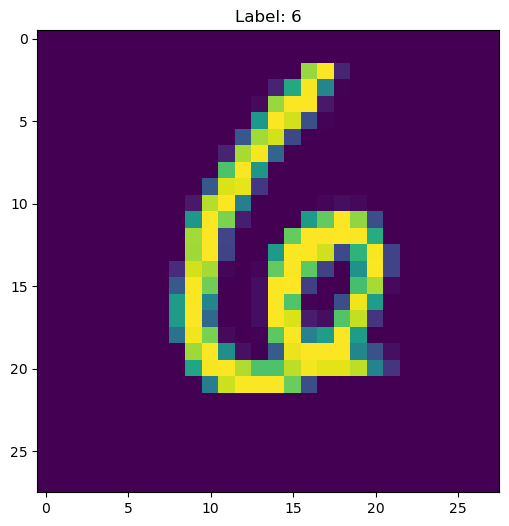

In [38]:
train_ds = torchvision.datasets.MNIST(root=DATASET_PATH, train=False, transform=None)

# Get an image from the test dataset.
digit, label = train_ds[123]

# Turn it into a tensor.
digit = transforms.ToTensor()(digit)

plt.figure(figsize=(6, 6))
plt.imshow(digit.squeeze())
plt.title(f'Label: {label}')
plt.show()

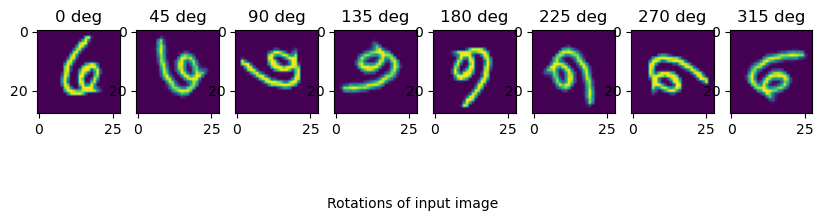

In [39]:
plt.rcParams['figure.figsize'] = [10, 3]

# Get a set of angles by which to rotate this image.
rots = torch.linspace(0, 360 - 360/8, 8)

# Rotate the input image and push it through the normalization transform.
rot_digit = torch.stack(tuple(torchvision.transforms.functional.rotate(digit, a.item(), torchvision.transforms.functional.InterpolationMode.BILINEAR) for a in rots))
rot_digit = torchvision.transforms.Normalize((0.1307,), (0.3081,))(rot_digit)

# Create a subfigure for every rotated input.
fig, ax = plt.subplots(1, rots.numel())

for idx, rotation in enumerate(rots):
    ax[idx].imshow(
        rot_digit[idx, :, :].squeeze()
    )
    ax[idx].set_title(f"{int(rotation)} deg")

fig.text(0.5, 0.04, 'Rotations of input image', ha='center')

plt.show()

In [40]:
# Forward it through the first few layers of the CNN.
cnn_out = cnn_model.model.first_conv(rot_digit)
cnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(cnn_out, cnn_out.shape[-3:]))
for i in range(2):
    cnn_out = cnn_model.model.convs[i](cnn_out)
    cnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(cnn_out, cnn_out.shape[-3:]))

# Let's also see what happens after we apply projection over remaining spatial dimensions.
projected_cnn_out = torch.nn.functional.adaptive_avg_pool2d(cnn_out, 1).squeeze()

# Forward it through the first few layers of the GCNN.
gcnn_out = gcnn_model.model.lifting_conv(rot_digit)
gcnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(gcnn_out, gcnn_out.shape[-4:]))
for i in range(2):
    gcnn_out = gcnn_model.model.gconvs[i](gcnn_out)
    gcnn_out = torch.nn.functional.relu(torch.nn.functional.layer_norm(gcnn_out, gcnn_out.shape[-4:]))

# And let's see what happens if we apply the projection on this equivariant representation.
projected_gcnn_out = torch.mean(gcnn_out, dim=(-3, -2, -1))

Let's first visualize the activations after the third convolution for a single channel of the regular CNN.

**Question**: What would you expect to see happening to the feature maps of the conventional CNN as the input is rotated?

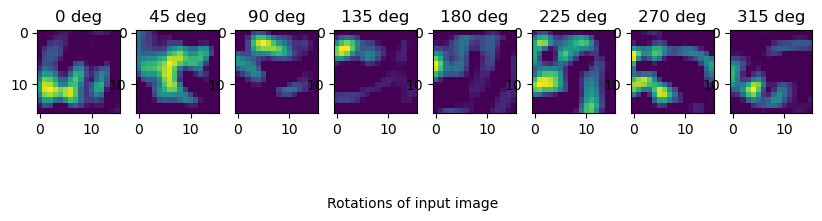

In [41]:
plt.rcParams['figure.figsize'] = [10, 3]

# Pick a channel to visualize
channel_idx = 2

# Create a subfigure for every rotated input
fig, ax = plt.subplots(1, rots.numel())

for idx, rotation in enumerate(rots):
    ax[idx].imshow(
        cnn_out[idx, out_channel_idx, :, :].detach().numpy()
    )
    ax[idx].set_title(f"{int(rotation)} deg")

fig.text(0.5, 0.04, 'Rotations of input image', ha='center')

plt.show()

**Question**: Explain what you see in the above images; how should we interpret what is happening to the feature maps as the input is rotated?

Next, we'll visualize activations after the third convolution operation for the G-CNN.

**Question**: What do you expect to see happen to the feature maps in the G-CNN as the input is rotated?

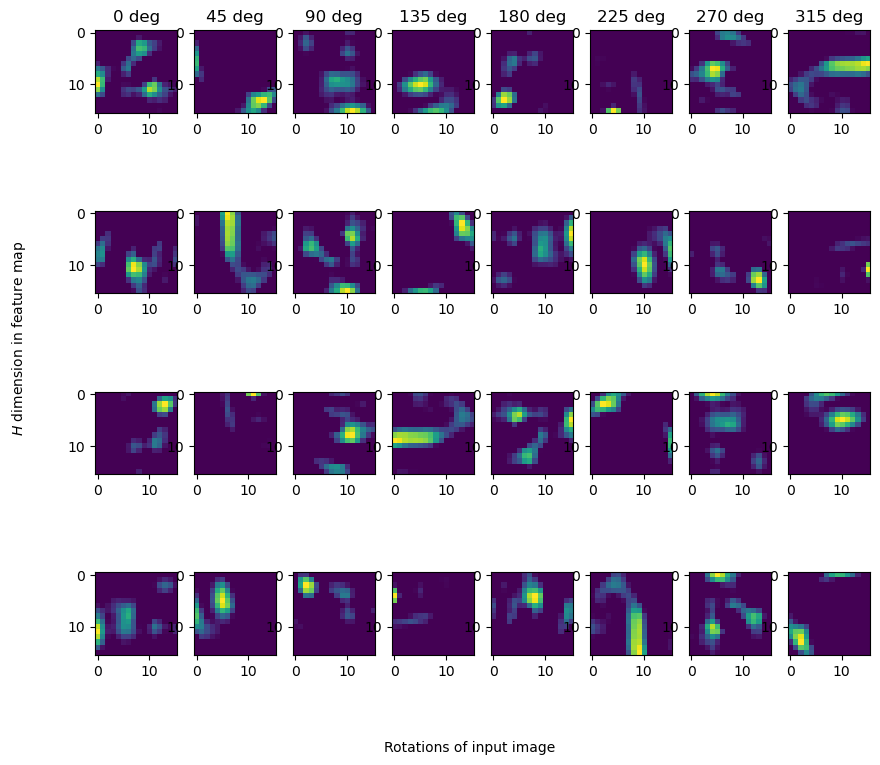

In [42]:
plt.rcParams['figure.figsize'] = [10, 9]

# Pick a channel to visualize
channel_idx = 2

# Create a subfigure for every rotated input and every group element
fig, ax = plt.subplots(gcnn_out.shape[2], rots.numel())

for idx, rotation in enumerate(rots):
    for group_element_idx in range(gcnn_out.shape[2]):
        ax[group_element_idx ,idx].imshow(
            gcnn_out[idx, out_channel_idx, group_element_idx, :, :].detach().numpy()
        )
    ax[0, idx].set_title(f"{int(rotation)} deg")
    

fig.text(0.5, 0.04, 'Rotations of input image', ha='center')
fig.text(0.04, 0.5, '$H$ dimension in feature map', va='center', rotation='vertical')

plt.show()

**Question**: Explain what you see in the above images; how should we interpret what is happening to the feature maps as the input is rotated? What happens after a 45 degree rotation? And a 90 degree rotation?

Lastly, we inspect the representations we obtain after the projection step for the CNN and GCNN. We visualize all channels. These are the representations on which the final linear layer(s) perform classification.

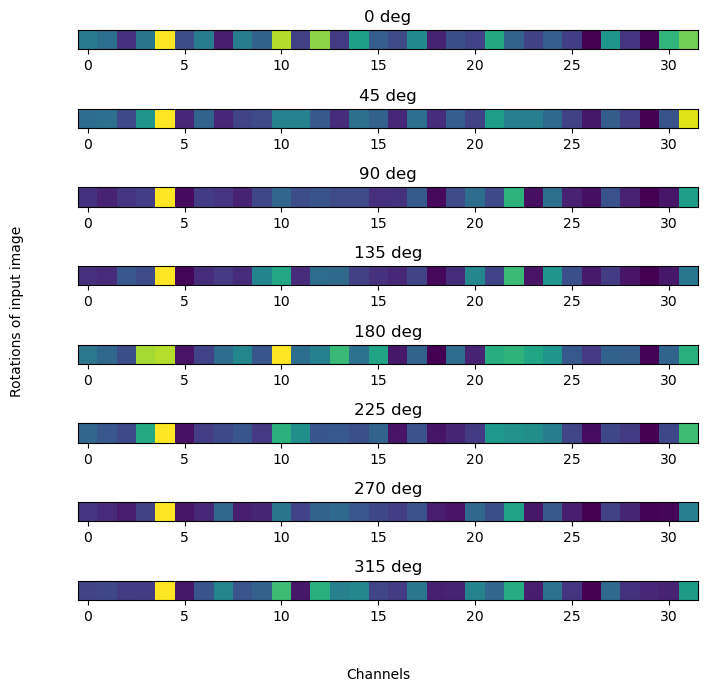

In [43]:
plt.rcParams['figure.figsize'] = [8, 8]

# Create a subfigure for every rotated input
fig, ax = plt.subplots(rots.numel(), 1)

for idx, rotation in enumerate(rots):
    ax[idx].imshow(
        projected_cnn_out[idx, None, :].detach().numpy()
    )
    ax[idx].set_title(f"{int(rotation)} deg")
    ax[idx].set_yticks([])

fig.text(0.5, 0.04, 'Channels', ha='center')
fig.text(0.04, 0.5, 'Rotations of input image', va='center', rotation='vertical')

plt.show()

**Question**: What happens to the learned representations as the input is rotated? What consequences do you think this has on the performance of the model?

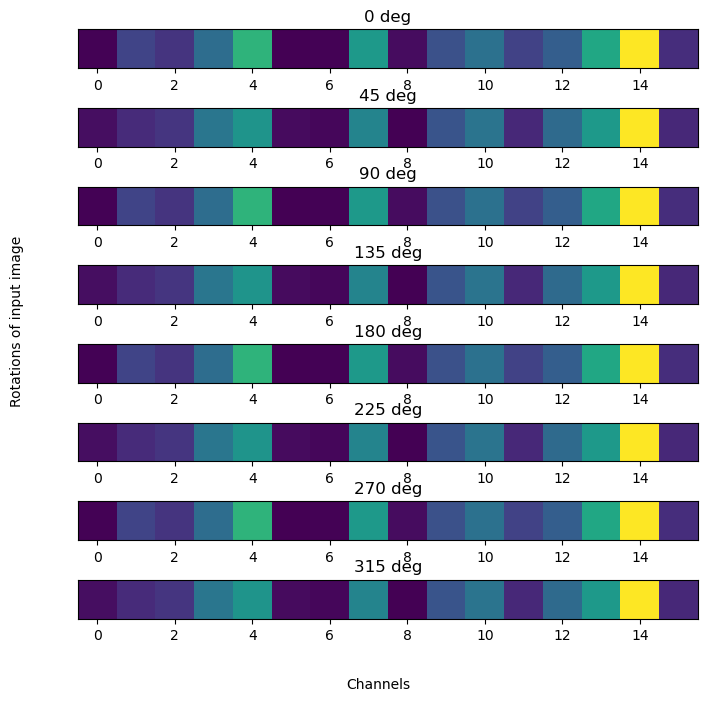

In [44]:
plt.rcParams['figure.figsize'] = [8, 8]

# Create a subfigure for every rotated input
fig, ax = plt.subplots(rots.numel(), 1)

for idx, rotation in enumerate(rots):
    ax[idx].imshow(
        projected_gcnn_out[idx, None, :].detach().numpy()
    )
    ax[idx].set_title(f"{int(rotation)} deg")
    ax[idx].set_yticks([])

fig.text(0.5, 0.04, 'Channels', ha='center')
fig.text(0.04, 0.5, 'Rotations of input image', va='center', rotation='vertical')

plt.show()

**Question**: Explain what you see above. What does this mean for the final of input samples that are rotated?

**Question**: Do you notice anything about the learned representations of 45 degree vs 90 degree rotated input samples? To what can we attribute this phenomenon do you think?

## 4. Concluding remarks

We've seen how to implement a basic regular group convolutional network equivariant to rotations of 90 degrees. A couple suggestions of things to ponder on. Include answers to these questions in your report:

*  What other groups could be interesting in computer vision problems? (these often come with their own interesting challenges). 
*  We used interpolation to obtain our values for transformed kernels. As mentioned, this makes our networks prone to interpolation artefacts. Would our interpolation implementation work well for other groups? Could you maybe think of other ways of defining the kernel over a continuous domain?
*  Here we worked with a one-dimensional group. What would it take to implement group convolutions for multidimensional groups $H$?
